In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

In [2]:
merged_df = pd.read_csv('../Data/merged.csv')
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='mixed', dayfirst=True, errors='coerce')
merged_df = merged_df.sort_values(["Symbol", "Date"])

merged_df.head()

,Symbol,GICS Sector,Headquarters Location,Founded,Date,Close,Volume,News - Positive Sentiment,News - Negative Sentiment,News - New Products,...,Close_lag2,Close_lag3,Close_lag4,Close_lag5,Close_lag6,Close_lag7,Close_lag8,Close_lag9,Close_lag10,Profit
0,A,Health Care,"Santa Clara, California",1999,2020-10-15,105.320000,723000,1.0,0.0,0.0,...,105.419998,105.430000,105.760002,104.160004,103.879997,101.629997,103.120003,100.010002,101.220001,1
1,A,Health Care,"Santa Clara, California",1999,2020-10-16,106.699997,1039400,0.0,0.0,1.0,...,105.059998,105.419998,105.430000,105.760002,104.160004,103.879997,101.629997,103.120003,100.010002,1
2,A,Health Care,"Santa Clara, California",1999,2020-10-19,105.489998,636000,0.0,0.0,1.0,...,105.320000,105.059998,105.419998,105.430000,105.760002,104.160004,103.879997,101.629997,103.120003,0
3,A,Health Care,"Santa Clara, California",1999,2020-10-20,105.610001,771000,2.0,0.0,0.0,...,106.699997,105.320000,105.059998,105.419998,105.430000,105.760002,104.160004,103.879997,101.629997,1
4,A,Health Care,"Santa Clara, California",1999,2020-10-21,104.830002,894000,0.0,0.0,0.0,...,105.489998,106.699997,105.320000,105.059998,105.419998,105.430000,105.760002,104.160004,103.879997,0


In [3]:
lag_cols   = [f"Close_lag{k}" for k in range(1, 11)]
news_cols  = [c for c in merged_df.columns if c.startswith("News -")]
num_features  = lag_cols + ["Volume"] + news_cols      

merged_df = pd.get_dummies(merged_df, columns=["GICS Sector"], drop_first=True, dtype="int")

sector_dummies = [c for c in merged_df.columns if c.startswith("GICS Sector_")]
feature_cols   = num_features + sector_dummies

cutoff_date = merged_df["Date"].quantile(0.8)

train = merged_df[merged_df["Date"] <= cutoff_date]
test  = merged_df[merged_df["Date"]  > cutoff_date]

X_train, y_train = train[feature_cols], train["Profit"]
X_test,  y_test  = test [feature_cols], test ["Profit"]

In [6]:
# Change to tensors
X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_t  = torch.tensor(X_test.values,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values,  dtype=torch.float32).view(-1, 1)

train_dl = DataLoader(TensorDataset(X_train_t, y_train_t),
                      batch_size=256, shuffle=True)

In [8]:
class MLP(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)      # logits
        )
    def forward(self, x): return self.net(x)

device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model    = MLP(X_train.shape[1]).to(device)
loss_fn  = nn.BCEWithLogitsLoss()
optimiser = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
epochs = 25
for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimiser.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward()
        optimiser.step()
    if (epoch+1) % 5 == 0:
        print(f"epoch {epoch+1:2d}/{epochs} - loss {loss.item():.4f}")

epoch  5/25 – loss 42.9792
epoch 10/25 – loss 0.6900
epoch 15/25 – loss 0.6978
epoch 20/25 – loss 0.6932
epoch 25/25 – loss 0.6963


In [10]:
model.eval()
with torch.no_grad():
    logits = model(X_test_t.to(device)).cpu().numpy().ravel()
    y_prob = 1 / (1 + np.exp(-logits))           # sigmoid
    y_pred = (y_prob > 0.5).astype(int)

print(f"\nAccuracy : {accuracy_score (y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall   : {recall_score   (y_test, y_pred, zero_division=0):.4f}")
print(f"F1-score : {f1_score       (y_test, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC  : {roc_auc_score  (y_test, y_prob):.4f}")


Accuracy : 0.4900
Precision: 0.4900
Recall   : 1.0000
F1-score : 0.6577
ROC-AUC  : 0.5000


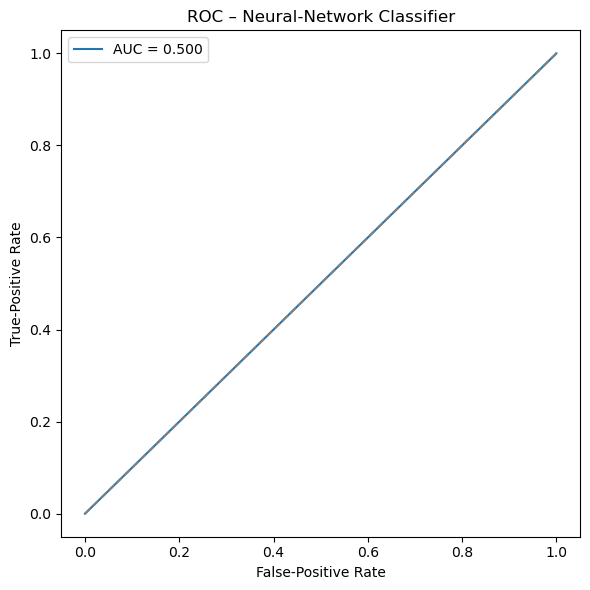

In [11]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], "--", color="grey")
plt.xlabel("False-Positive Rate"); plt.ylabel("True-Positive Rate")
plt.title("ROC – Neural-Network Classifier")
plt.legend(); plt.tight_layout(); plt.show()